## Import Library

In [1]:
import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", package],
            stdout=subprocess.DEVNULL,  # Nonaktifkan output
            stderr=subprocess.DEVNULL
        )
        print("Done")
    except subprocess.CalledProcessError:
        print("Gagal install:", package)

# Install googletrans versi yang stabil
install_package("googletrans==4.0.0-rc1")
install_package("emoji==2.11.0")
install_package("nltk")
install_package("pySastrawi")

Done
Done
Done
Done


In [40]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
np.random.seed(0)

# Visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt

# Library untuk waktu, ekspresi reguler, dan teks
import datetime as dt
import re
import string
import emoji

# Tokenisasi dan stopwords Bahasa Indonesia
import tensorflow as tf
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC, LinearSVC
from tensorflow.keras.utils import to_categorical

In [4]:
import nltk

# Unduh resource penting: tokenisasi dan daftar stopwords
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Load Dataset

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Submission Dicoding/bsi_reviews.csv")

df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,ed8e728a-8726-4ad5-a028-ef3be1824557,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,membantu,5,0,NaN,2025-05-31 09:02:05,Assalamualaikum Bapak Muhlis. Terima kasih ata...,2025-05-31 10:19:07,NaN
1,3fba0d79-a7e9-4714-a88d-dc66e086766d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,anehhh vermuk aj susah bangett..,1,0,1.0.5,2025-05-31 08:05:18,"Assalamualaikum Bapak Idam, mohon maaf atas ke...",2025-05-31 08:23:39,1.0.5
2,4c03e5c3-5fb4-4e33-ba4e-ff60384e00f1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Lelet, tidak bisa di buka",1,1,1.0.5,2025-05-31 06:56:48,"Assalamualaikum Bapak Hen, mohon maaf atas ket...",2025-05-31 07:26:36,1.0.5
3,6f2ffd72-be50-4c9d-b047-c6aa53ab157a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"aplikasi ini sangat membantu, mempermudah tran...",5,0,NaN,2025-05-31 05:01:48,"Assalamualaikum Ibu Effi, terima kasih atas ap...",2025-05-31 07:22:53,NaN
4,e00d2deb-cd69-49ce-8b2c-ca7764cbb572,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,loading trus,1,1,1.0.5,2025-05-31 04:50:52,"Assalamualaikum Bapak Ruddin, mohon maaf atas ...",2025-05-31 07:22:01,1.0.5


In [6]:
# Menghitung missing value
df.isna().sum()

,0
reviewId,0
userName,0
userImage,0
content,0
score,0
thumbsUpCount,0
reviewCreatedVersion,1659
at,0
replyContent,37
repliedAt,37


In [7]:
duplicate_rows = df[df.duplicated()]
print("Jumlah baris duplikat:", len(duplicate_rows))

Jumlah baris duplikat: 0


In [8]:
# Summary dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              10000 non-null  object
 1   userName              10000 non-null  object
 2   userImage             10000 non-null  object
 3   content               10000 non-null  object
 4   score                 10000 non-null  int64 
 5   thumbsUpCount         10000 non-null  int64 
 6   reviewCreatedVersion  8341 non-null   object
 7   at                    10000 non-null  object
 8   replyContent          9963 non-null   object
 9   repliedAt             9963 non-null   object
 10  appVersion            8341 non-null   object
dtypes: int64(2), object(9)
memory usage: 859.5+ KB


## Preprocessing Data

In [9]:
# Hapus kolom pada DataFrame yang tidak digunakan
df = df.drop(columns=['reviewId', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'replyContent',
                      'repliedAt', 'appVersion', 'userName', 'at'])
print(df.columns)

Index(['content', 'score'], dtype='object')


<Axes: title={'center': 'Persebaran Data Score'}, xlabel='score'>

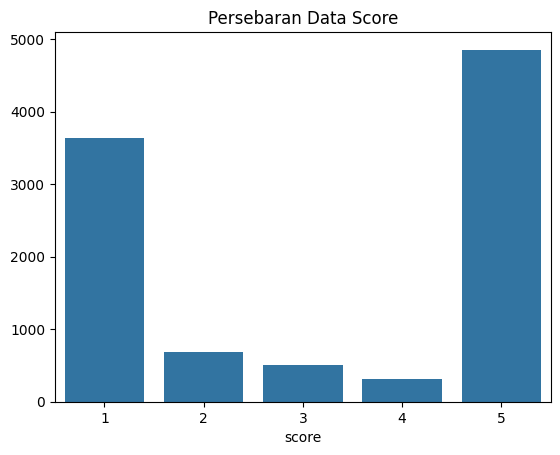

In [10]:
# Persebaran data berdasarkan kolom score
result = df.groupby(['score']).size()
plt.title('Persebaran Data Score')
sns.color_palette("viridis")

sns.barplot(x = result.index, y = result.values)

Dapat dilihat bahwa Jumlah komentar buruk (1) dan baik (5) hampir seimbang, hal ini menandakan tidak banyak komentar netral pada aplikasi tersebut.

In [11]:
def clean_text_full(text):
    # Hapus emoticon klasik seperti :) :D :-P
    text = re.sub(r'[:;=8][\-~]?[)DPOp\(\/|\\]', '', text)

    # Hapus emoji unicode
    text = emoji.replace_emoji(text, replace='')

    # Hapus URL
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Hapus mention (@user)
    text = re.sub(r'@\w+', '', text)

    # Hapus hashtag tapi simpan kata-nya (contoh: #happy → happy)
    text = re.sub(r'#', '', text)

    # Hapus simbol seperti $, %, &, *, dll
    text = re.sub(r'[$%^&*()_+={}[\]|\\<>/~`]', '', text)

    # Hapus angka jika tidak dibutuhkan (opsional)
    text = re.sub(r'\d+', '', text)

    # Hapus tanda baca & karakter non-alfanumerik (selain spasi)
    text = re.sub(r'[^\w\s]', '', text)

    # Hapus extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# df['clean_text'] = df['content'].apply(clean_text_full)

In [12]:
def caseFoldingText(text):
    return text.lower()

def tokenizingText(text):
    return word_tokenize(text)

def filteringText(tokens):
    listStopwords = set(stopwords.words('indonesian')).union(stopwords.words('english'))

    # Tambahan stopwords informal
    tambahan_stopwords = {
        'ya', 'yg', 'ga', 'gak', 'nya', 'sih', 'nih', 'deh', 'loh', 'kayak', 'dah',
        'ku', 'mu', 'lah', 'ampun', 'banget', 'bang', 'bgt', 'plis', 'pls', 'wkwk'
    }
    listStopwords.update(tambahan_stopwords)

    return [word for word in tokens if word not in listStopwords]

def stemmingText(filtered_tokens):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return [stemmer.stem(word) for word in filtered_tokens]

def toSentence(stemmed_tokens):
    return ' '.join(stemmed_tokens)

def fix_slangwords(text):
    # Kamus kata tidak baku (slang) ke bentuk baku
    slangwords = {
        "gk": "tidak", "ga": "tidak", "gak": "tidak", "nggak": "tidak", "tdk": "tidak",
        "tp": "tapi", "tpi": "tapi", "dgn": "dengan", "sm": "sama", "jg": "juga",
        "dr": "dari", "lg": "lagi", "sy": "saya", "aq": "aku", "gue": "saya", "gw": "saya",
        "pls": "tolong", "plis": "tolong", "trs": "terus", "udh": "sudah", "udah": "sudah",
        "blm": "belum", "km": "kamu", "mu": "kamu", "lo": "kamu", "lho": "kamu",
        "bgt": "banget", "bgt.": "banget", "btw": "ngomong-ngomong", "dpt": "dapat",
        "yg": "yang", "ajg": "anjing", "anj": "anjing", "bgs": "bagus", "bgtu": "begitu"
    }

    words = word_tokenize(text)

    # Revisi slang jika ada di kamus
    revised_text = [slangwords[word] if word in slangwords else word for word in words]

    return ' '.join(revised_text)

In [13]:
df['text_clean'] = df['content'].apply(clean_text_full)
df['text_casefoldingText'] = df['text_clean'].apply(caseFoldingText)
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)
df['text_stemming'] = df['text_stopword'].apply(stemmingText)
df['text_final'] = df['text_stemming'].apply(toSentence)

In [14]:
df.to_csv('data_ulasan_BSI.csv', index=False)

## Labelling

In [15]:
import requests
import csv
from io import StringIO

positif_lexicon = {}
negatif_lexicon = {}

# Daftar kata positif
resp_pos = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if resp_pos.ok:
    data_pos = csv.reader(StringIO(resp_pos.text))
    for item in data_pos:
        positif_lexicon[item[0]] = int(item[1])
else:
    print("Gagal mengambil data positif")

# Daftar kata negatif
resp_neg = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if resp_neg.ok:
    data_neg = csv.reader(StringIO(resp_neg.text))
    for item in data_neg:
        negatif_lexicon[item[0]] = int(item[1])
else:
    print("Gagal mengambil data negatif")

In [16]:
def analisis_sentimen(text):
    total_score = 0

    for token in text.split():
        if token in positif_lexicon:
            total_score += positif_lexicon[token]
        elif token in negatif_lexicon:
            total_score += negatif_lexicon[token]

    if total_score > 0:
        label = 'positive'
    elif total_score < 0:
        label = 'negative'
    else:
        label = 'neutral'

    return total_score, label

In [17]:
hasil_analisis = df['text_final'].apply(analisis_sentimen)

df['polarity_score'] = hasil_analisis.map(lambda x: x[0])
df['polarity'] = hasil_analisis.map(lambda x: x[1])

print(df['polarity'].value_counts())

polarity
positive    5760
negative    3353
neutral      887
Name: count, dtype: int64


## Exploratory Data Anslysis

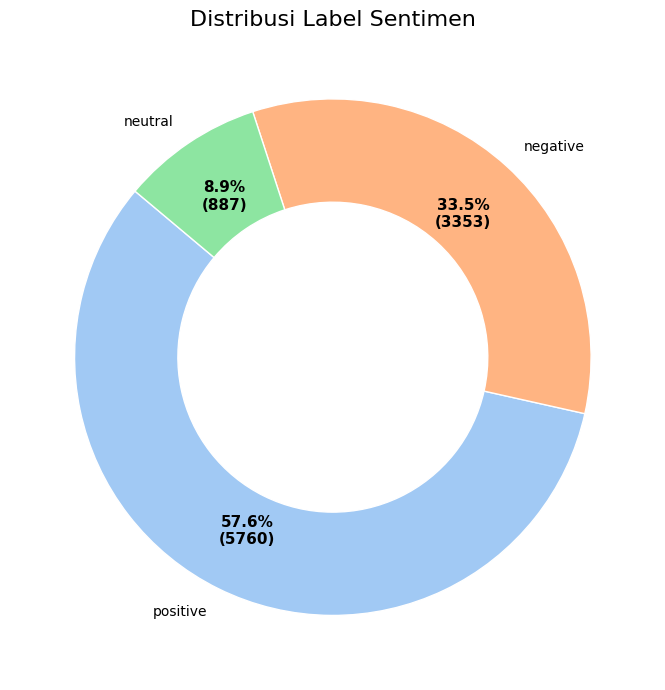

In [18]:
label_counts = df['polarity'].value_counts()
total = label_counts.sum()

# Warna dari seaborn
colors = sns.color_palette('pastel')[0:len(label_counts)]

# Fungsi untuk menampilkan persentase dan nilai absolut
def make_autopct(values):
    def my_autopct(pct):
        total_val = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({total_val})'
    return my_autopct

# Pie chart
plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(
    label_counts,
    labels=label_counts.index,
    colors=colors,
    autopct=make_autopct(label_counts),
    startangle=140,
    wedgeprops=dict(width=0.4, edgecolor='w'),
    pctdistance=0.75,
)

# Format teks
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

# Judul
plt.title('Distribusi Label Sentimen', fontsize=16)
plt.tight_layout()
plt.show()

/tmp/ipython-input-19-1218380748.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words_df, x='tfidf_score', y='term', palette='mako')


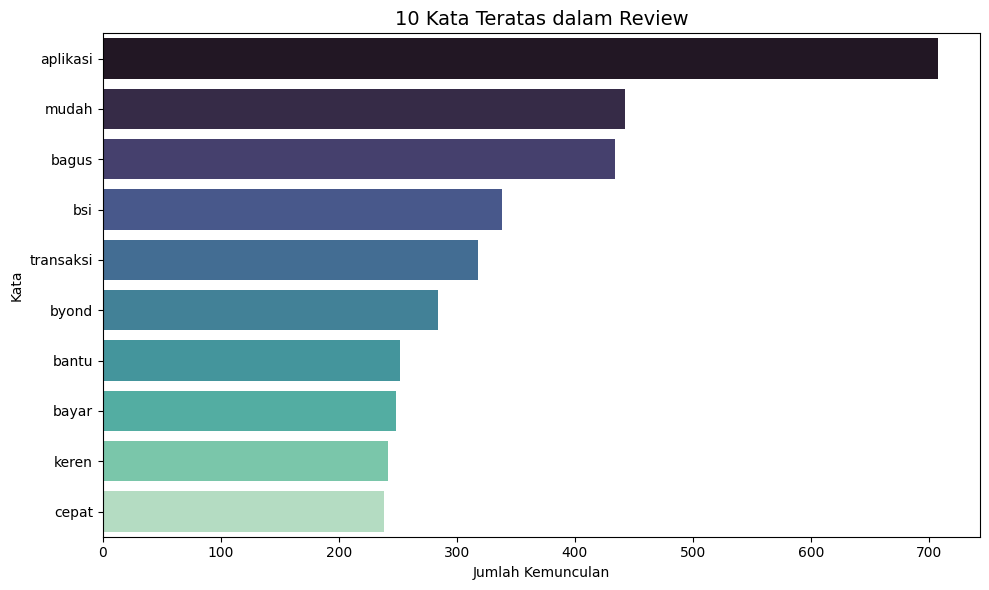

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['text_final'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

top_words_df = tfidf_df.sum().sort_values(ascending=False).head(10).reset_index()
top_words_df.columns = ['term', 'tfidf_score']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_words_df, x='tfidf_score', y='term', palette='mako')
plt.title('10 Kata Teratas dalam Review', fontsize=14)
plt.xlabel('Jumlah Kemunculan')
plt.ylabel('Kata')
plt.tight_layout()
plt.show()

## Word Cloud

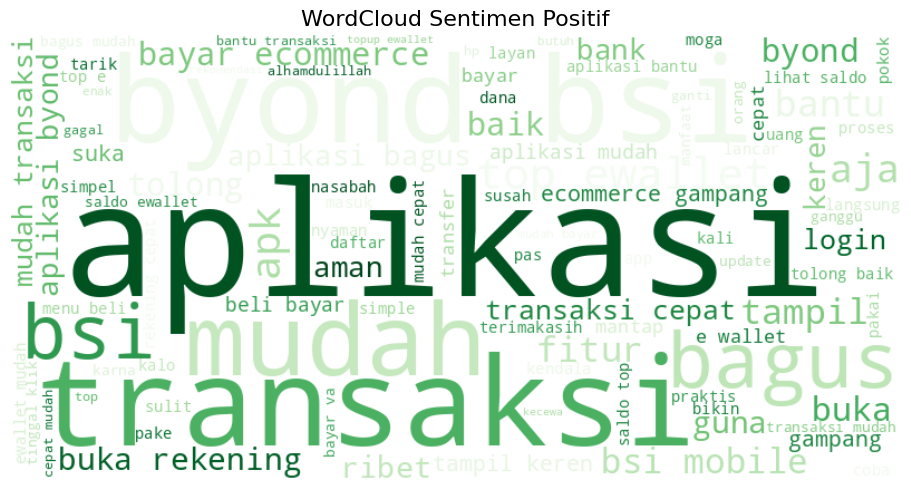

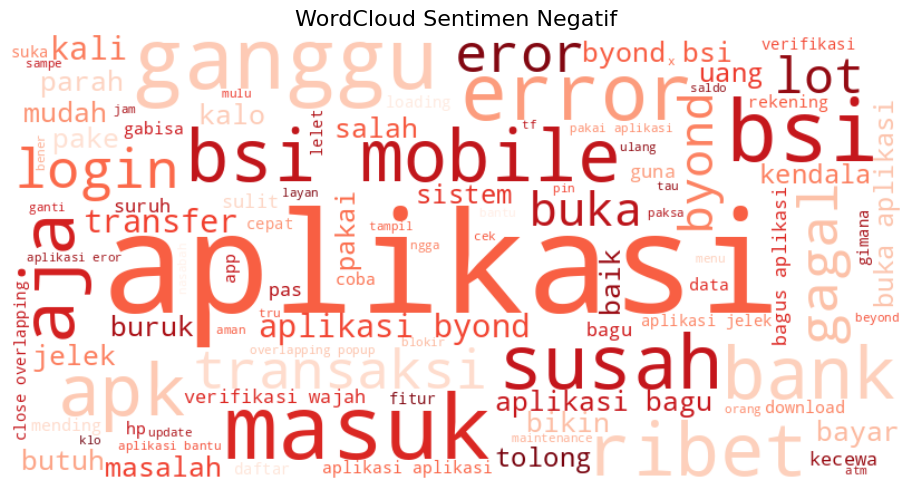

In [20]:
# Pisahkan berdasarkan label
positive_text = ' '.join(df[df['polarity'] == 'positive']['text_final'])
negative_text = ' '.join(df[df['polarity'] == 'negative']['text_final'])

# Fungsi untuk buat wordcloud
def generate_wordcloud(text, title, colormap='viridis'):
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap=colormap, max_words=100).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Tampilkan WordCloud untuk setiap label
generate_wordcloud(positive_text, 'WordCloud Sentimen Positif', colormap='Greens')
generate_wordcloud(negative_text, 'WordCloud Sentimen Negatif', colormap='Reds')

## TF-IDF

In [21]:
X_text = df['text_final']
y_label = df['polarity']

tfidf_vectorizer = TfidfVectorizer(min_df=10, max_df=0.85)
X_tfidf = tfidf_vectorizer.fit_transform(X_text)

print("Jumlah fitur TF-IDF:", len(tfidf_vectorizer.get_feature_names_out()))

Jumlah fitur TF-IDF: 838


In [22]:
# Konversi sparse matrix TF-IDF ke DataFrame
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Simpan array untuk seleksi
X_array = np.array(df_tfidf)
y_array = np.array(y_label)

# Seleksi fitur dengan Chi-Square
selector = SelectKBest(chi2, k=1000)
X_selected = selector.fit_transform(X_array, y_array)

print("Jumlah fitur awal:", X_array.shape[1])
print("Jumlah fitur terpilih:", X_selected.shape[1])

Jumlah fitur awal: 838
Jumlah fitur terpilih: 838


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1000 is greater than n_features=838. All the features will be returned.
  warnings.warn(


In [23]:
# Terapkan SMOTE untuk menangani ketidakseimbangan kelas
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_selected, y_array)

# Split data menjadi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.1, random_state=42
)

# Cek ukuran hasil split
print("Ukuran X_train :", X_train.shape)
print("Ukuran y_train :", y_train.shape)
print("Ukuran X_test  :", X_test.shape)
print("Ukuran y_test  :", y_test.shape)

Ukuran X_train : (15552, 838)
Ukuran y_train : (15552,)
Ukuran X_test  : (1728, 838)
Ukuran y_test  : (1728,)


In [24]:
# Membangun arsitektur ANN
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(3, activation='softmax')  # 3 kelas: positive, negative, neutral
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
# Inisialisasi encoder
encoder = LabelEncoder()

# Encode y_train dan y_test
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Ubah ke bentuk one-hot
y_train_onehot = to_categorical(y_train_encoded)
y_test_onehot = to_categorical(y_test_encoded)

print("Mapping label ke angka:")
for label, code in zip(encoder.classes_, encoder.transform(encoder.classes_)):
    print(f"{label}: {code}")

Mapping label ke angka:
negative: 0
neutral: 1
positive: 2


In [27]:
# Custom Callback untuk menghentikan training jika akurasi tinggi
class StopTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.99 and logs.get('val_accuracy') > 0.99:
            print("\nAkurasi train dan validasi sudah >99%, training dihentikan.")
            self.model.stop_training = True

# EarlyStopping untuk validasi loss
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [28]:
history = model.fit(
    X_train, y_train_onehot,
    validation_data=(X_test, y_test_onehot),
    epochs=100,
    batch_size=64,
    callbacks=[StopTrainingCallback(), early_stop]
)

Epoch 1/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5644 - loss: 1.0299 - val_accuracy: 0.4693 - val_loss: 0.9263
Epoch 2/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8348 - loss: 0.4200 - val_accuracy: 0.8171 - val_loss: 0.4449
Epoch 3/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8946 - loss: 0.2811 - val_accuracy: 0.9161 - val_loss: 0.2534
Epoch 4/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9176 - loss: 0.2250 - val_accuracy: 0.9294 - val_loss: 0.2116
Epoch 5/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9399 - loss: 0.1810 - val_accuracy: 0.9329 - val_loss: 0.2057
Epoch 6/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9521 - loss: 0.1440 - val_accuracy: 0.9398 - val_loss: 0.1893
Epoch 7/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9566 - loss: 0.1298 - val_accuracy: 0.9473 - val_loss: 0.1760
Epoch 8/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9599 - loss: 0.1228 - val_accu

In [29]:
# Evaluation
train_acc = model.evaluate(X_train, y_train_onehot, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test_onehot, verbose=0)[1]

print(f"\nTrain Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")


Train Accuracy: 0.9915, Test Accuracy: 0.9543


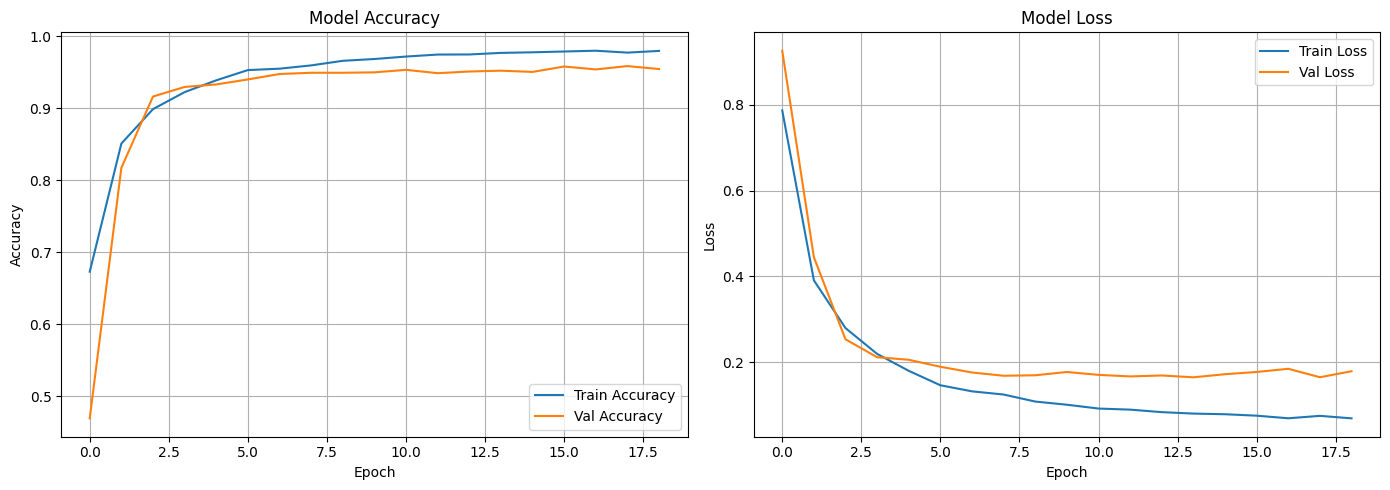

In [30]:
# Plot training history side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Val Loss')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [42]:
# --------- Skema 1: RF ---------
from sklearn.feature_extraction.text import TfidfVectorizer

# Ambil fitur dan label
X_rf = df['text_final']
y_rf = df['polarity']

# Konversi teks ke TF-IDF
tfidf_rf = TfidfVectorizer(min_df=10, max_df=0.85)
X_tfidf_rf = tfidf_rf.fit_transform(X_rf)

print("Jumlah fitur TF-IDF (Random Forest):", X_tfidf_rf.shape[1])

# Inisialisasi model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 5-Fold Cross Validation
cv_scores = cross_val_score(rf_model, X_tfidf_rf, y_rf, cv=5, scoring='accuracy')

print("Akurasi per fold:", cv_scores)
print("Akurasi rata-rata:", round(cv_scores.mean() * 100, 2), "%")

Jumlah fitur TF-IDF (Random Forest): 838
Akurasi per fold: [0.851  0.8475 0.8345 0.8445 0.8395]
Akurasi rata-rata: 84.34 %


In [43]:
# --------- Skema 2: RF ---------
fitur_tfidf = X_tfidf_rf.toarray()
label_target = np.array(y_rf)

selector = SelectKBest(score_func=chi2, k=1000)
fitur_terpilih = selector.fit_transform(fitur_tfidf, label_target)

# Inisialisasi SMOTE
smote_rf = SMOTE(random_state=42)

# Terapkan SMOTE pada data hasil seleksi fitur
X_smote_rf, y_smote_rf = smote_rf.fit_resample(fitur_terpilih, label_target)

# Membagi data hasil SMOTE ke training dan testing
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_smote_rf, y_smote_rf, test_size=0.1, random_state=42
)

# Buat model Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Latih model menggunakan data train
rf_classifier.fit(X_train_rf, y_train_rf)

y_pred_rf = rf_classifier.predict(X_test_rf)

akurasi_rf = accuracy_score(y_test_rf, y_pred_rf)
print("Akurasi Random Forest pada data test:", round(akurasi_rf * 100, 2), "%")

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1000 is greater than n_features=838. All the features will be returned.
  warnings.warn(


Akurasi Random Forest pada data test: 90.86 %


In [44]:
# --------- Skema 3: SVM ---------
# Inisialisasi model SVM dengan kernel linear (cocok untuk TF-IDF)
svm_model = LinearSVC(random_state=42)

# Latih model menggunakan data hasil SMOTE
svm_model.fit(X_train_rf, y_train_rf)

y_pred_svm = svm_model.predict(X_test_rf)

# Hitung akurasi
akurasi_svm = accuracy_score(y_test_rf, y_pred_svm)
print("Akurasi SVM pada data test:", round(akurasi_svm * 100, 2), "%")

Akurasi SVM pada data test: 88.83 %


# 📊 Analisis Sentimen: Komentar Aplikasi BSI SuperApp di Playstore

## 📁 Dataset
- Dataset: `bsi_reviews.csv`
- Fitur teks: `content`
- Label target: `polarity` (3 kelas: positif, negatif, netral)

---

## 🧪 Skema Pelatihan

### ✅ Skema 1: Random Forest + TF-IDF + 5-Fold Cross Validation
- **Model**: Random Forest Classifier
- **Fitur**: TF-IDF (min_df=5, max_df=0.85)
- **Pembagian data**: 5-Fold CV
- **Hasil Akurasi per Fold**:
  - [0.851, 0.8475, 0.8345, 0.8445, 0.8395]
- **Rata-rata Akurasi**: **84.34%**

> 🔎 Cocok sebagai baseline awal, namun belum mencapai ambang batas 85%+.

---

### ✅ Skema 2: Random Forest + TF-IDF + Chi-Square + SMOTE + 90/10 Split
- **Model**: Random Forest Classifier
- **Fitur**: TF-IDF + Chi-Square (k=1000)
- **Teknik Imbang Kelas**: SMOTE
- **Pembagian Data**: 90% Train / 10% Test
- **Akurasi Test**: **90.86%**

> 🥇 Model terbaik dari ketiga skema. SMOTE dan seleksi fitur membantu peningkatan akurasi signifikan.

---

### ✅ Skema 3: SVM + TF-IDF + SMOTE + 90/10 Split
- **Model**: Support Vector Machine (LinearSVC)
- **Fitur**: TF-IDF
- **Teknik Imbang Kelas**: SMOTE
- **Akurasi Test**: **88.83%**

> 🔁 Performa tinggi, hanya sedikit di bawah Random Forest.

---

## 📌 Ringkasan Skema dan Akurasi

| Skema   | Model | Teknik Tambahan        | Akurasi Test |
|---------|--------|------------------------|--------------|
| Skema 1 | RF     | TF-IDF + 5-Fold CV     | 84.34%       |
| Skema 2 | RF     | TF-IDF + Chi2 + SMOTE  | **90.86%**   |
| Skema 3 | SVM    | TF-IDF + SMOTE         | 88.83%       |

---

## 🔎 Rekomendasi
- Kita dapat menggunakan **Skema 2 (RF + TF-IDF + Chi2 + SMOTE)** untuk produksi.
- Bisa di tambahkan **GridSearchCV** untuk mencari kombinasi `n_estimators`, `max_depth`, dll.
- Dapat mencobamenggunakan metode tambahan seperti **n-gram** atau model deep learning lain jika ingin meningkatkan akurasi lebih lanjut.

---

